## EDA for H&M dataset  

### It also enables panadas dataframe optimization for reducing memory usage

Reference Notebook Link: https://www.kaggle.com/vanguarde/h-m-eda-first-look/notebook  

The dataset comprises of 5 segregations, please find the details below:  
1. images: This folder consists of images for most of the articles that are being sold in H&M however all articls don't have respective images.  
2. articles.csv: This csv file consists of metadata for each of the article which are getting sold under H&M banner. It has total 25 columns for each article including metadata information such as product type, product name, product description, etc.  
3. customers.csv: This csv file consists of metadata for each customer id. It has total 7 columns and includes general information regarding a speicific customer such as H&M club member status, age, etc.  
4. transactions_train.csv: This csv file consists of transaction information of any specific article id which any of the customer id has purchased and at what price point the transactions were made and also when was the transaction made.  
5. sample_submission.csv: This csv files consists of customer ids for which the predictions are to be made as to what are the list of article ids that a specific customer id will purchase within a span of one week i.e. 7 days after the training date ends.

In [1]:
# Importing Libraries
import re
import gc
import string
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from textwrap import wrap
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
gc.collect()

0

In [2]:
# Optimize dataframes
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
articles_data = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/articles.csv")
customers_data = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/customers.csv")
transactions_data = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv")

In [4]:
# Optimizing the dataframes
articles_data = reduce_mem_usage(articles_data)
customers_data = reduce_mem_usage(customers_data)
transactions_data = reduce_mem_usage(transactions_data)

Mem. usage decreased to 13.59 Mb (32.5% reduction)
Mem. usage decreased to 49.72 Mb (32.1% reduction)
Mem. usage decreased to 697.26 Mb (42.5% reduction)


In [5]:
gc.collect()

21

## Exploring Articles Metadata

In [6]:
# List all columns present in article metadata
articles_data.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

In [7]:
articles_data.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


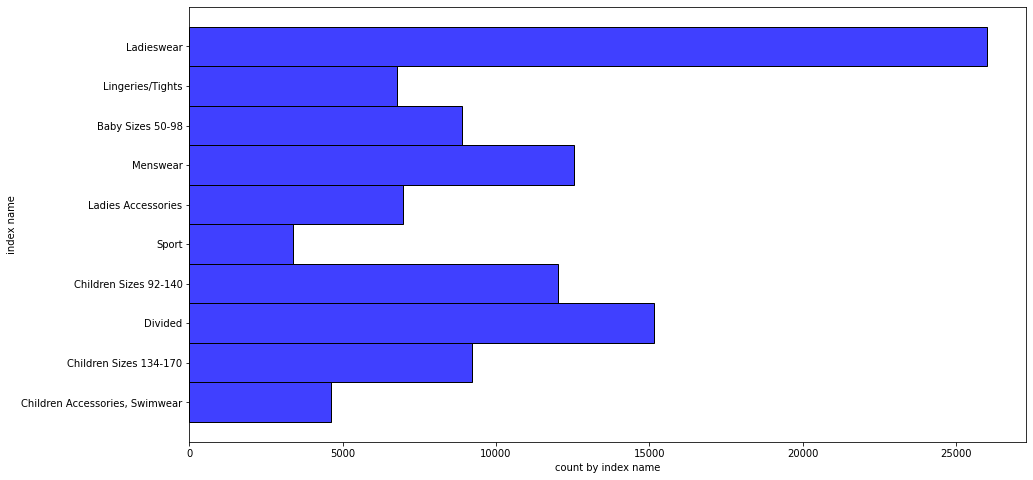

In [8]:
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.histplot(data=articles_data, y='index_name', color='blue')
ax.set_xlabel('count by index name')
ax.set_ylabel('index name')
plt.show()

From the above horizontal bar graph, its easily visible that out of 10 categories of products, the count of ladieswear articles is the highest in the metadata and is more than 25000 in number followed by Divided, Menswear, etc.

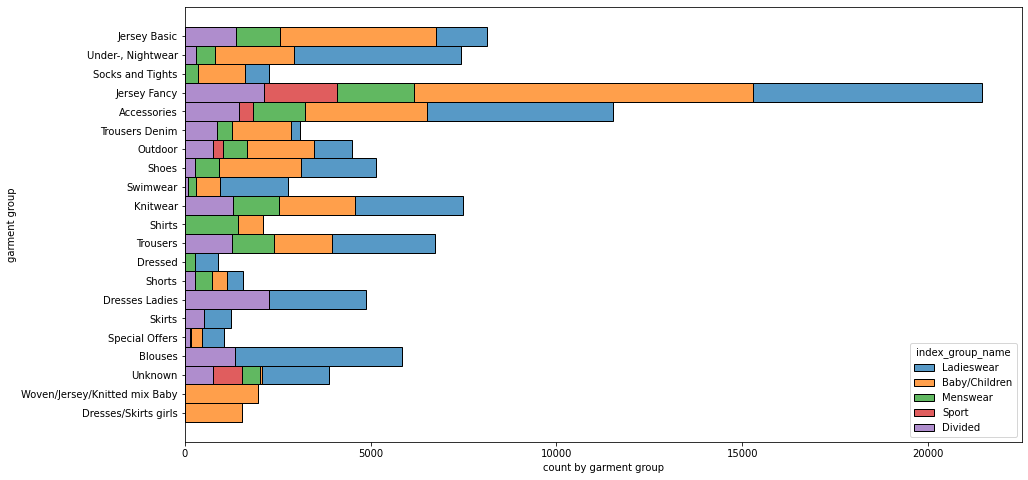

In [9]:
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.histplot(data=articles_data, y='garment_group_name', color='orange', hue='index_group_name', multiple="stack")
ax.set_xlabel('count by garment group')
ax.set_ylabel('garment group')
plt.show()

The garments grouped by index: Jersey fancy is the most frequent garment, especially for women and baby/children. The next by number is accessories which is followed by Jersey Basic, Under-nightwear, etc

Lets look up to the combination counts for index group name and index name

In [10]:
articles_data.groupby(['index_group_name', 'index_name']).count()['article_id']

index_group_name  index_name                    
Baby/Children     Baby Sizes 50-98                   8875
                  Children Accessories, Swimwear     4615
                  Children Sizes 134-170             9214
                  Children Sizes 92-140             12007
Divided           Divided                           15149
Ladieswear        Ladies Accessories                 6961
                  Ladieswear                        26001
                  Lingeries/Tights                   6775
Menswear          Menswear                          12553
Sport             Sport                              3392
Name: article_id, dtype: int64

Lets look up to the combination counts for product group name and product name

In [11]:
pd.options.display.max_rows = None
articles_data.groupby(['product_group_name', 'product_type_name']).count()['article_id']

product_group_name     product_type_name       
Accessories            Accessories set                 7
                       Alice band                      6
                       Baby Bib                        3
                       Bag                          1280
                       Beanie                         56
                       Belt                          458
                       Bracelet                      180
                       Braces                          3
                       Bucket hat                      7
                       Cap                            13
                       Cap/peaked                    573
                       Dog Wear                       20
                       Earring                      1159
                       Earrings                       11
                       Eyeglasses                      2
                       Felt hat                       10
                       Giftbox          

In [12]:
# Extract number of unique columns values under each column
for col_name in articles_data.columns:
    un_n = articles_data[col_name].nunique()
    print(f'No of unique {col_name}: {un_n}')

No of unique article_id: 105542
No of unique product_code: 47224
No of unique prod_name: 45875
No of unique product_type_no: 132
No of unique product_type_name: 131
No of unique product_group_name: 19
No of unique graphical_appearance_no: 30
No of unique graphical_appearance_name: 30
No of unique colour_group_code: 50
No of unique colour_group_name: 50
No of unique perceived_colour_value_id: 8
No of unique perceived_colour_value_name: 8
No of unique perceived_colour_master_id: 20
No of unique perceived_colour_master_name: 20
No of unique department_no: 299
No of unique department_name: 250
No of unique index_code: 10
No of unique index_name: 10
No of unique index_group_no: 5
No of unique index_group_name: 5
No of unique section_no: 57
No of unique section_name: 56
No of unique garment_group_no: 21
No of unique garment_group_name: 21
No of unique detail_desc: 43404


## Exploring Textual description of articles

### Steps inolved:
#### Preprocessing Steps:
1. Check missing values and remove them
2. Expand Contractions
3. Lowercase the descriptions
4. Remove digits and words containing digits 
5. Remove punctuations

#### EDA for Textual Description:
1. Stopwords Removal  
2. Lemmatization  
3. Creating Document Matrix

In [13]:
articles_desc_data = articles_data[['article_id','detail_desc']]

### Preprocessing Steps

#### 1. Check missing values and remove them


In [14]:
# Counting number of null detailed descriptions for articles
articles_desc_data.isnull().sum()

article_id       0
detail_desc    416
dtype: int64

In [15]:
articles_desc_data.dropna(inplace=True)
articles_desc_data.isnull().sum()

/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


article_id     0
detail_desc    0
dtype: int64

In [16]:
articles_desc_data['detail_desc'].unique()

array(['Jersey top with narrow shoulder straps.',
       'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.',
       'Semi shiny nylon stockings with a wide, reinforced trim at the top. Use with a suspender belt. 20 denier.',
       ...,
       'Short, A-line dress in jersey with a round neckline and V-shaped opening at the front with narrow ties. Long, voluminous raglan sleeves and wide cuffs with covered buttons.',
       'Large plastic hair claw.',
       'Calf-length dress in ribbed jersey made from a cotton blend. Low-cut V-neck at the back, dropped shoulders and long, wide sleeves that taper to the cuffs. Unlined.'],
      dtype=object)

#### 2. Remove Contractions

In [17]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

In [18]:
# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
articles_desc_data['detail_desc']=articles_desc_data['detail_desc'].apply(lambda x:expand_contractions(x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


The expand_contractions function uses regular expressions to map the contractions in the text to their expanded forms from the dictionary. 

#### 3. Lowercase the decriptions

In [19]:
articles_desc_data['detail_desc_cleaned']=articles_desc_data['detail_desc'].apply(lambda x: x.lower())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### 4. Remove digits and words containing digits

In [20]:
articles_desc_data['detail_desc_cleaned']=articles_desc_data['detail_desc_cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### 5. Remove punctuations and spaces

In [21]:
articles_desc_data['detail_desc_cleaned']=articles_desc_data['detail_desc_cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
articles_desc_data['detail_desc_cleaned']=articles_desc_data['detail_desc_cleaned'].apply(lambda x: re.sub(' +',' ',x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
articles_desc_data['detail_desc_cleaned'].unique()

array(['jersey top with narrow shoulder straps',
       'microfibre tshirt bra with underwired moulded lightly padded cups that shape the bust and provide good support narrow adjustable shoulder straps and a narrow hookandeye fastening at the back without visible seams for greater comfort',
       'semi shiny nylon stockings with a wide reinforced trim at the top use with a suspender belt denier',
       ...,
       'short aline dress in jersey with a round neckline and vshaped opening at the front with narrow ties long voluminous raglan sleeves and wide cuffs with covered buttons',
       'large plastic hair claw',
       'calflength dress in ribbed jersey made from a cotton blend lowcut vneck at the back dropped shoulders and long wide sleeves that taper to the cuffs unlined'],
      dtype=object)

### EDA for Textual Description

#### 
1. Stopwords Removal 
2. Lemmatization  
3. Finally, we will utilize word cloud library to represent the data

We will use spacy to remove the stopwords and present the lemma form of toekns in article descriptions

In [23]:
# Loading english spacy model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

lemmatized_desc_list = [(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))(x) for x in articles_desc_data['detail_desc_cleaned'].unique()]
len(lemmatized_desc_list)

42964

In [24]:
lemmatized_desc_list[:5]

['jersey narrow shoulder strap',
 'microfibre tshirt bra underwired mould lightly pad cup shape bust provide good support narrow adjustable shoulder strap narrow hookandeye fasten visible seam great comfort',
 'semi shiny nylon stocking wide reinforce trim use suspender belt denier',
 'tight builtin support lift black deni light amber deni',
 'semi shiny tight shape tummy thigh calf encourage blood circulation leg elasticate waist']

In [25]:
# Extracting only unique cleaned and lemmatized description for fitting it to Document Term Matrix
print('Shape of overall articles dataframe: %s' %(str(articles_desc_data.shape[0])))
print('Total no of unique article descriptions: %s' %(len(lemmatized_desc_list)))

Shape of overall articles dataframe: 105126
Total no of unique article descriptions: 42964


In [26]:
# Creating Document Term Matrix
cv=CountVectorizer(analyzer='word')
data=cv.fit_transform(lemmatized_desc_list)
df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm.index = lemmatized_desc_list
df_dtm.shape

(42964, 3050)

In [27]:
df_dtm.head(3)

,accentuate,accentuated,access,accessory,accompany,ace,acetate,acetateeva,acrylic,act,...,zipdetail,zipdown,zipped,zipping,zips,zipthrough,ziptop,zipup,zlideon,ﬁbre
jersey narrow shoulder strap,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
microfibre tshirt bra underwired mould lightly pad cup shape bust provide good support narrow adjustable shoulder strap narrow hookandeye fasten visible seam great comfort,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
semi shiny nylon stocking wide reinforce trim use suspender belt denier,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# Function for generating word clouds
def generate_wordcloud(data,title):
#     wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
    wc = WordCloud(width=400, height=330, max_words=150, background_color ='white', min_font_size=4).generate_from_frequencies(data)
    plt.figure(figsize=(15,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title('\n'.join(wrap(title,60)),fontsize=13)
    plt.show()

In [29]:
# Transposing document term matrix
df_dtm=df_dtm.transpose()
df_dtm.head(3)

,jersey narrow shoulder strap,microfibre tshirt bra underwired mould lightly pad cup shape bust provide good support narrow adjustable shoulder strap narrow hookandeye fasten visible seam great comfort,semi shiny nylon stocking wide reinforce trim use suspender belt denier,tight builtin support lift black deni light amber deni,semi shiny tight shape tummy thigh calf encourage blood circulation leg elasticate waist,opaque matt tight deni,sweatshirt soft organic cotton pressstud shoulder size month month pressstud brush inside,soft bandeau bras soft jersey support silicone trim,fit soft stretch jersey wide neckline long sleeve,trouser sweatshirt fabric elasticate drawstre waist pocket pocket rib hem soft brush inside,...,jogger soft sweatshirt fabric elasticate drawstre waist diagonal pocket slim leg ribbed hem,small fold hair brush rhinestonedecorated lid mirror inside diameter cm,fineknit tight elasticate waist thin opaque give appearance overtheknee sock,fit calflength dress viscose jersey standup collar conceal zip double layer wrapover drape section closefitte extralong sleeve asymmetric skirt high slit line,fit jersey round neckline extralong sleeve additional drape layer,sock fineknit cotton blend small motif elasticate top,loosefitte sport vest ribbed fastdrye functional fabric recycled polyester racer round hem,short aline dress jersey round neckline vshape opening narrow tie long voluminous raglan sleeve wide cuff cover button,large plastic hair claw,calflength dress ribbed jersey cotton blend lowcut vneck drop shoulder long wide sleeve taper cuff unlined
accentuate,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
accentuated,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
access,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


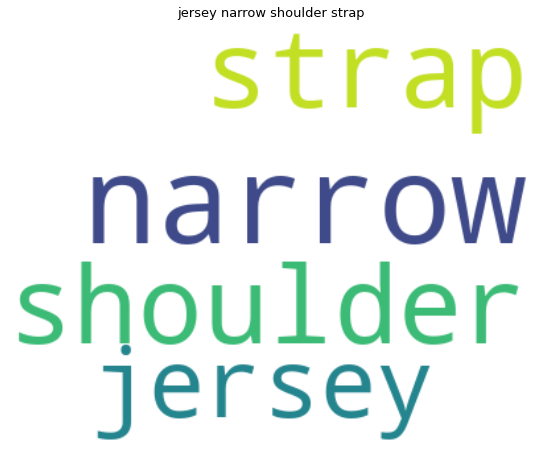

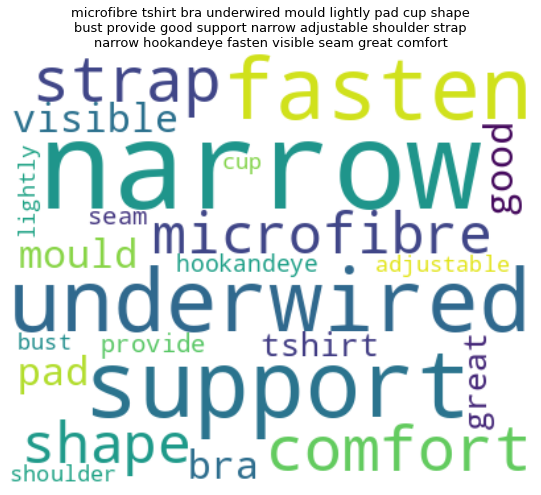

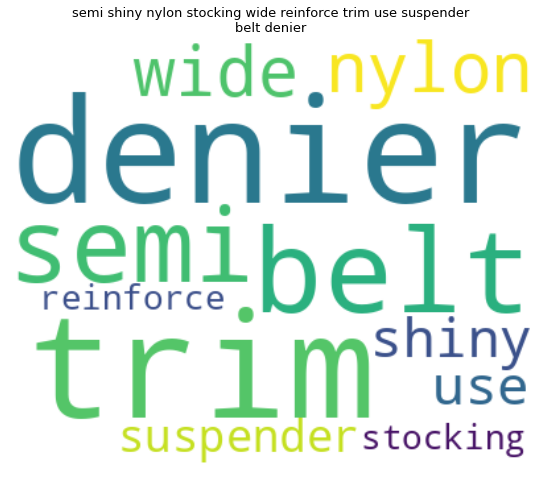

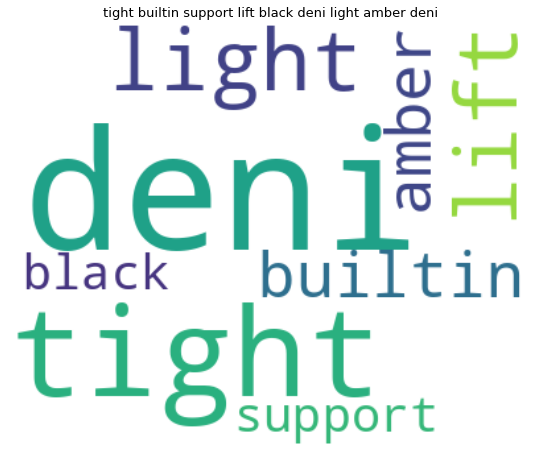

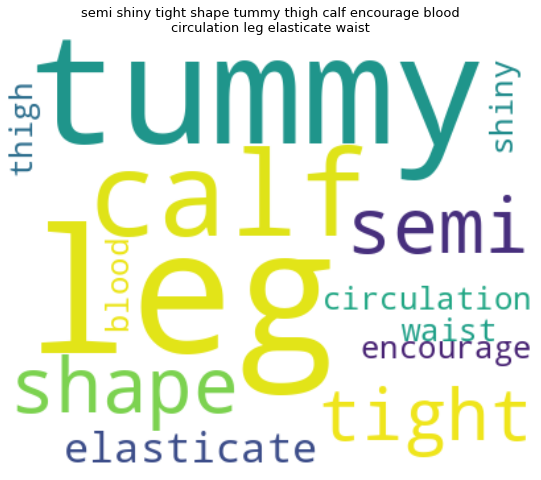

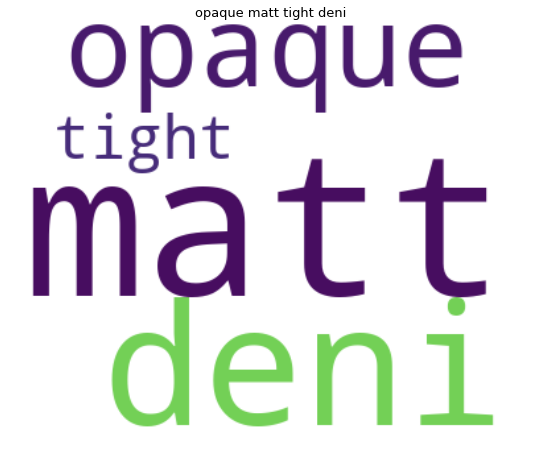

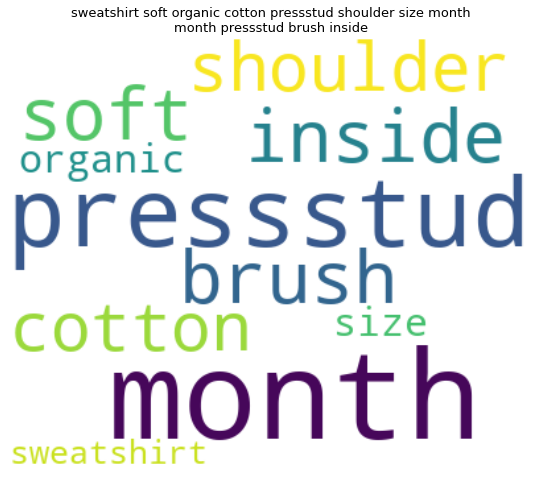

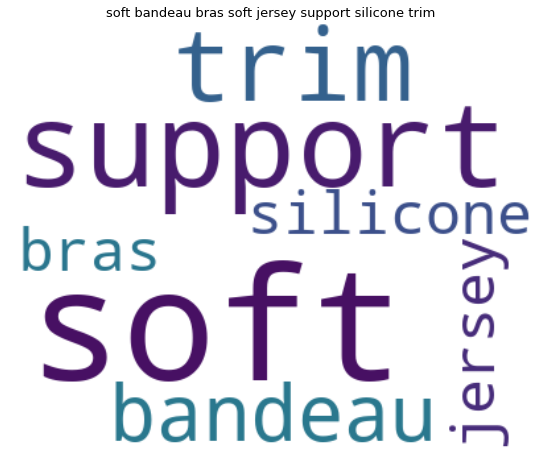

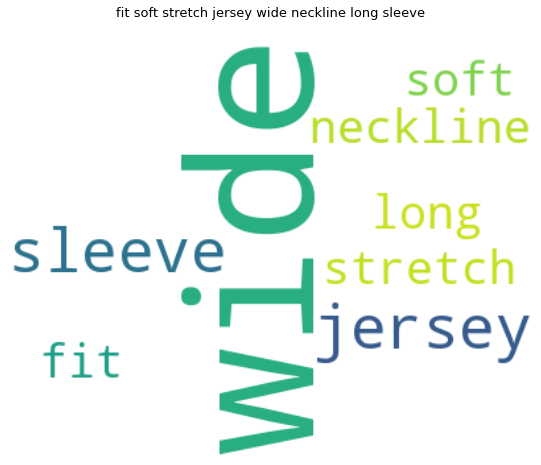

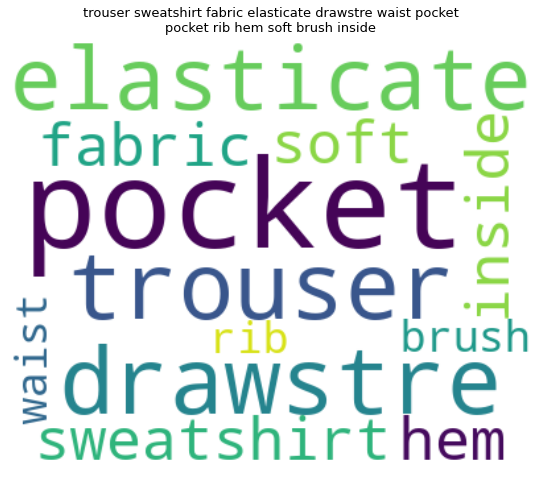

In [30]:
# Plotting word cloud for each unique first 10 articles
for index,product in enumerate(df_dtm.columns[:10]):
  generate_wordcloud(df_dtm[product].sort_values(ascending=False),product)

From the world clouds above, we can observer that certain words like naroow, shoulder, belt, pocket, jersey, soft, etc are widely being used under descriptions. This proves that most of the article description that H&M uses describes the physical aspects of the article as well as 

In [31]:
# Clearing out local variables for freeing up RAM
del contractions_re, articles_desc_data, nlp, cv, data, df_dtm, lemmatized_desc_list
gc.collect()

42998

## Exploring Customer Metadata

In [32]:
# List all columns present in article metadata
customers_data.columns

Index(['customer_id', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'postal_code'],
      dtype='object')

In [33]:
customers_data.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [34]:
# Counting number of null detailed descriptions for customers
customers_data.isnull().sum()

customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16009
age                        15861
postal_code                    0
dtype: int64

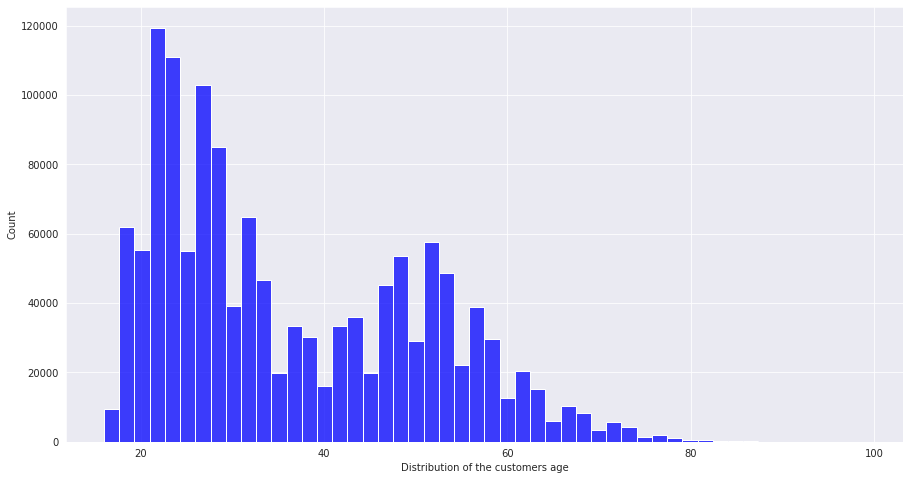

In [35]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(15,8))
ax = sns.histplot(data=customers_data, x='age', bins=50, color='blue')
ax.set_xlabel('Distribution of the customers age')
plt.show()

From the above bar plot, its clear that the customer category which shops at H&M are from age range of 21 to 25 which is mostly the early 20s and relevant customers are also seen within age range of 44 to 50. The reasons may be:  
1. Youth styling is better at H&M  
2. Since, dress styles which cater to older category which are mostly subtle in nature are also widely available.

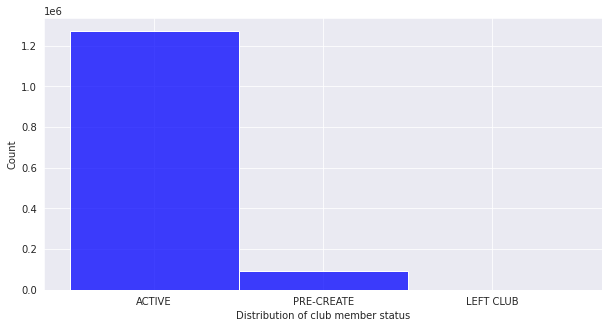

In [36]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=customers_data, x='club_member_status', color='blue')
ax.set_xlabel('Distribution of club member status')
plt.show()

In [37]:
customers_data.loc[customers_data.club_member_status.isin(['ACTIVE'])].shape[0]/customers_data.shape[0] * 100

92.74850945349058

Almost 92.7 i.e. 93 % of the customers are active members of H&M.

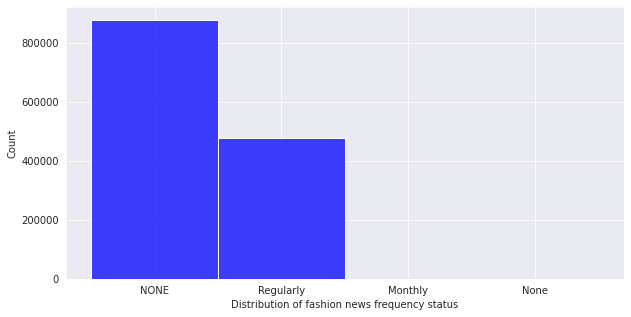

In [38]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=customers_data, x='fashion_news_frequency', color='blue')
ax.set_xlabel('Distribution of fashion news frequency status')
plt.show()

In [39]:
customers_data.loc[customers_data.fashion_news_frequency.isin(['NONE','None'])].shape[0]/customers_data.shape[0] * 100

63.97418329713261

Almost 63.9 i.e. 64 % of the customers receive no communication regrading any latest fashion trends in H&M otherwise they dont agree to receive any notifications for the same

## Exploring Transaction Metadata

In [40]:
# List all columns present in article metadata
transactions_data.columns

Index(['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id'], dtype='object')

In [41]:
transactions_data.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050842,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030487,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015236,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016937,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016937,2


In [42]:
pd.set_option('display.float_format', '{:.4f}'.format)
transactions_data.describe()

,article_id,price,sales_channel_id
count,31788324.0000,31788324.0000,31788324.0000
mean,696227219.0051,NaN,1.7040
std,133448003.4874,0.0000,0.4565
min,108775015.0000,0.0000,1.0000
25%,632803008.0000,0.0158,1.0000
50%,714582003.0000,0.0254,2.0000
75%,786524001.0000,0.0339,2.0000
max,956217002.0000,0.5913,2.0000


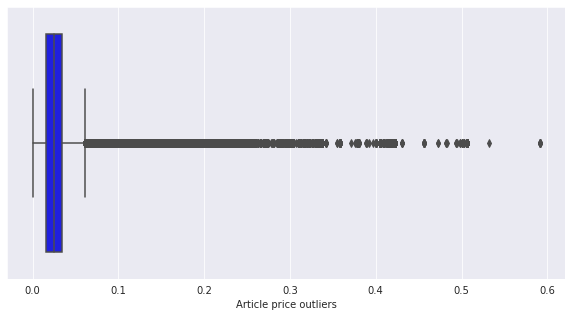

In [43]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.boxplot(data=transactions_data, x='price', color='blue')
ax.set_xlabel('Article price outliers')
plt.show()

Finding the best transaction date range with the highest transactions made

In [44]:
transactions_data.groupby(['t_dat']).agg({'price':'sum'}).sort_values('price', ascending=False)[:10]

,price
t_dat,
2019-09-28,6160.0000
2019-11-29,4444.0000
2018-09-29,4072.0000
2020-04-11,3962.0000
2018-11-23,3892.0000
2019-11-28,3102.0000
2019-04-06,3100.0000
2019-11-03,2738.0000
2019-05-16,2594.0000


We can clearly observe that the topmost sells happened during the time of season sale, clearance sale or christmas celebration kind of shopping and the trend could be observed across the data of 3 years 

Top 10 customers based on number of transcation that were made

In [45]:
transactions_data.groupby(['customer_id']).count().sort_values(by='price', ascending=False)['price'][:10]

customer_id
be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee985513d9e8e53c6d91b    1895
b4db5e5259234574edfff958e170fe3a5e13b6f146752ca066abca3c156acc71    1441
49beaacac0c7801c2ce2d189efe525fe80b5d37e46ed05b50a4cd88e34d0748f    1364
a65f77281a528bf5c1e9f270141d601d116e1df33bf9df512f495ee06647a9cc    1361
cd04ec2726dd58a8c753e0d6423e57716fd9ebcf2f14ed6012e7e5bea016b4d6    1237
55d15396193dfd45836af3a6269a079efea339e875eff42cc0c228b002548a9d    1208
c140410d72a41ee5e2e3ba3d7f5a860f337f1b5e41c27cf9bda5517c8774f8fa    1170
8df45859ccd71ef1e48e2ee9d1c65d5728c31c46ae957d659fa4e5c3af6cc076    1169
03d0011487606c37c1b1ed147fc72f285a50c05f00b9712e0fc3da400c864296    1157
6cc121e5cc202d2bf344ffe795002bdbf87178054bcda2e57161f0ef810a4b55    1143
Name: price, dtype: int64

In [46]:
gc.collect()

21495

### Merge transaction details with articles

In [47]:
articles_data_extract = articles_data[['article_id', 'prod_name', 'product_type_name', 'product_group_name', 'index_name']]

In [48]:
articles_data_extract = transactions_data[['customer_id', 'article_id', 'price', 't_dat']].merge(articles_data_extract, on='article_id', how='left')
articles_data_extract.head()

,customer_id,article_id,price,t_dat,prod_name,product_type_name,product_group_name,index_name
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.0508,2018-09-20,Atlanta Push Body Harlow,Underwear body,Underwear,Lingeries/Tights
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.0305,2018-09-20,Rae Push (Melbourne) 2p,Bra,Underwear,Lingeries/Tights
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.0152,2018-09-20,Inca Jumper,Sweater,Garment Upper body,Divided
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.0169,2018-09-20,W YODA KNIT OL OFFER,Sweater,Garment Upper body,Ladieswear
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.0169,2018-09-20,W YODA KNIT OL OFFER,Sweater,Garment Upper body,Ladieswear


In [49]:
articles_data_extract.shape

(31788324, 8)

In [50]:
# Optimizing transaction dataframe having article info 
articles_data_extract = reduce_mem_usage(articles_data_extract)
gc.collect()

Mem. usage decreased to 1879.57 Mb (0.0% reduction)


84

In [51]:
# sns.set_style("darkgrid")
# f, ax = plt.subplots(figsize=(20,12))
# ax = sns.boxplot(data=articles_data_extract[['price','product_group_name']], x='price', y='product_group_name')
# ax.set_xlabel('Product group level pricing outliers', fontsize=15)
# ax.set_ylabel('Index names for product groups', fontsize=15)
# ax.xaxis.set_tick_params(labelsize=15)
# ax.yaxis.set_tick_params(labelsize=15)
# plt.show()

In the above boxplot, we see outliers for group name prices. Lower/Upper/Full body have a huge price variance. I guess it could be like some unique collections, relative to casual ones. Some high price articles even belong to accessories group.

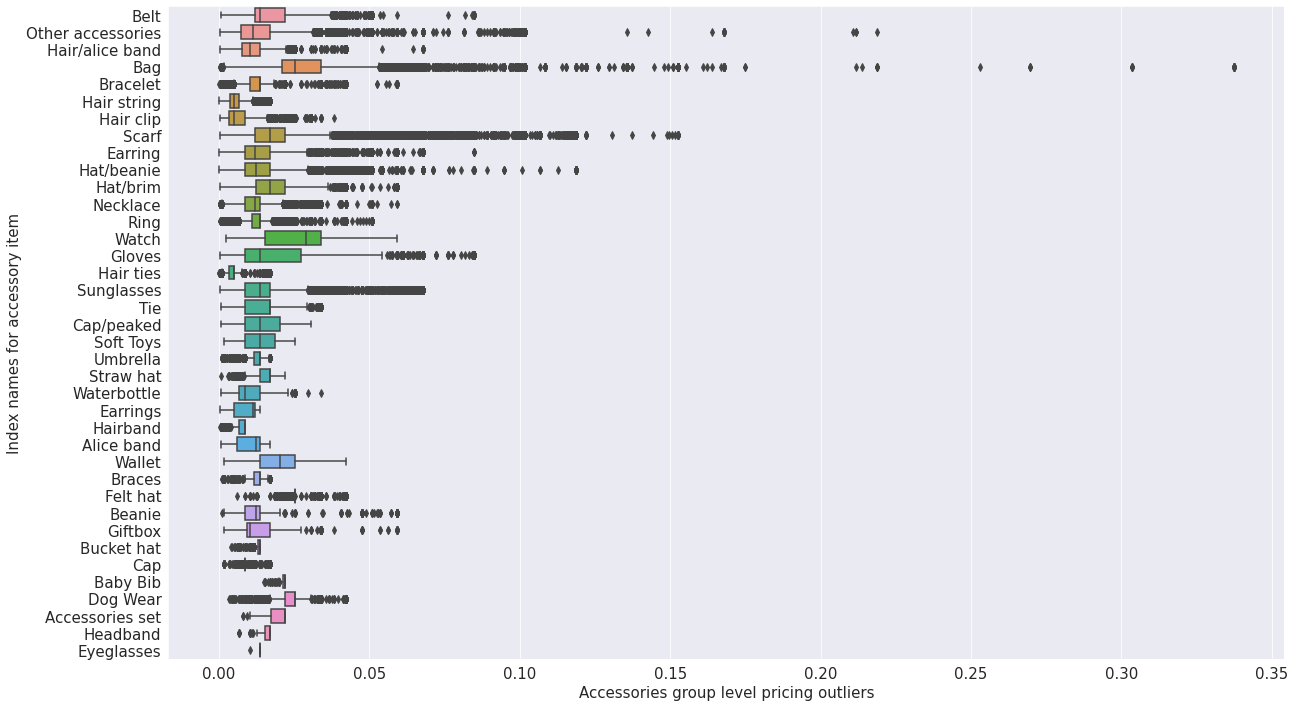

In [52]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(20,12))
_ = articles_data_extract[articles_data_extract['product_group_name'] == 'Accessories']
ax = sns.boxplot(data=_, x='price', y='product_type_name')
ax.set_xlabel('Accessories group level pricing outliers', fontsize=15)
ax.set_ylabel('Index names for accessory item', fontsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
del _
plt.show()

Lets look at boxplot prices according to accessories product group and find the reasons of high prices inside this specific group. We can easily observe that the largest outliers can be found among bags, which is logical enough. In addition, scarves and other accessories have articles with prices highly contrasting to the rest of garments.

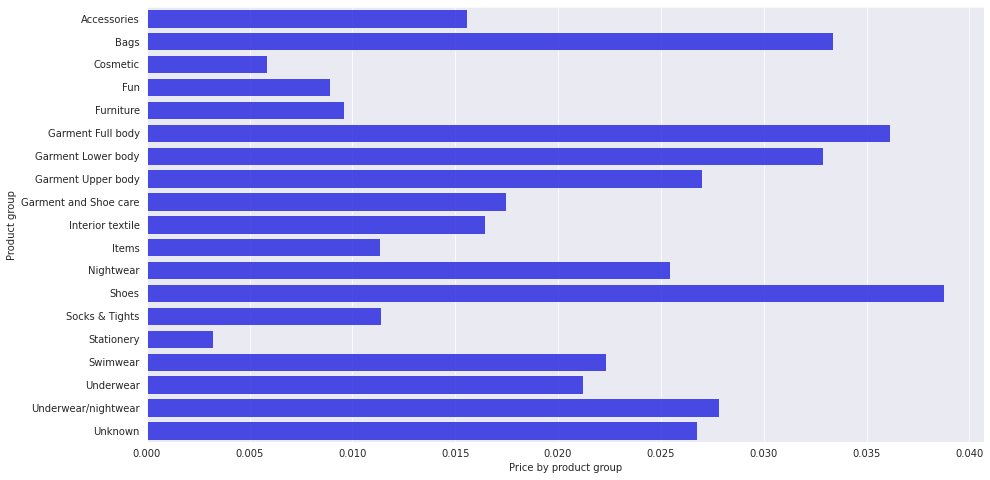

In [53]:
articles_index = articles_data_extract[['product_group_name', 'price']].groupby('product_group_name').mean()
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(15,8))
ax = sns.barplot(x=articles_index.price, y=articles_index.index, color='blue', alpha=0.8)
ax.set_xlabel('Price by product group')
ax.set_ylabel('Product group')
plt.show()

From the above bar plot it is clearly visible that we are seeing the means are seen in below mentioned product group names. Top 10 product group names are:  
Shoes  
Garment Full body  
Bags  
Garment Lower body  
Underwear/nightwear  
Swimwear  
Garment and Shoe Care  
Interior textile  
Accessories  
Socks & Tights

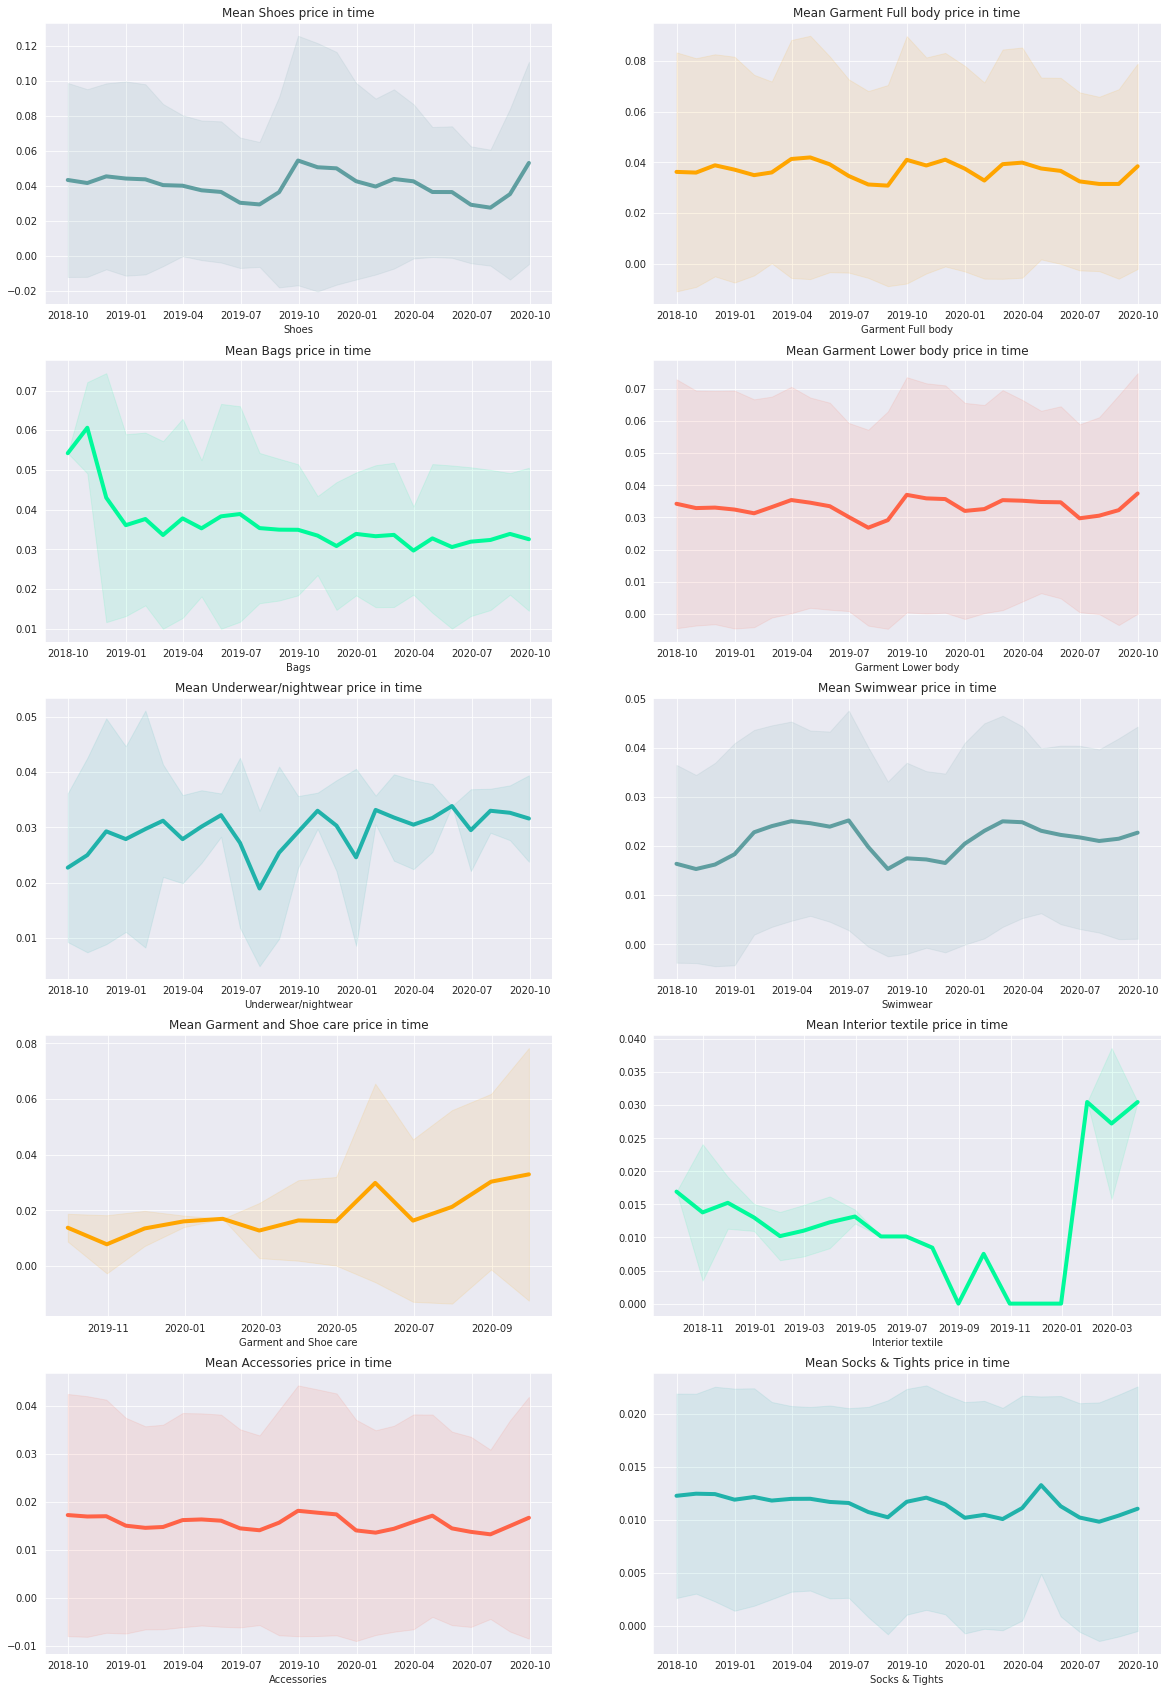

In [54]:
articles_data_extract['t_dat'] = pd.to_datetime(articles_data_extract['t_dat'])

product_list = ['Shoes', 'Garment Full body', 'Bags', 'Garment Lower body', 'Underwear/nightwear','Swimwear','Garment and Shoe care','Interior textile','Accessories','Socks & Tights']
colors = ['cadetblue', 'orange', 'mediumspringgreen', 'tomato', 'lightseagreen', 'cadetblue', 'orange', 'mediumspringgreen', 'tomato', 'lightseagreen']
k = 0
f, ax = plt.subplots(5, 2, figsize=(20, 30))
for i in range(5):
    for j in range(2):
        try:
            product = product_list[k]
            articles_for_merge_product = articles_data_extract[articles_data_extract.product_group_name == product_list[k]]
            series_mean = articles_for_merge_product[['t_dat', 'price']].groupby(pd.Grouper(key="t_dat", freq='M')).mean().fillna(0)
            series_std = articles_for_merge_product[['t_dat', 'price']].groupby(pd.Grouper(key="t_dat", freq='M')).std().fillna(0)
            ax[i, j].plot(series_mean, linewidth=4, color=colors[k])
            ax[i, j].fill_between(series_mean.index, (series_mean.values-2*series_std.values).ravel(), 
                             (series_mean.values+2*series_std.values).ravel(), color=colors[k], alpha=.1)
            ax[i, j].set_title(f'Mean {product_list[k]} price in time')
            ax[i, j].set_xlabel('month')
            ax[i, j].set_xlabel(f'{product_list[k]}')
            k += 1
        except IndexError:
            ax[i, j].set_visible(False)
plt.show()